In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path 

from tests import *

from fnmatch import fnmatch
from plotting import plot_qdc, plot_tdc, plot_testpulse, plot_disc_calibration


/eos/user/j/jowulff/mambaforge/lib/python3.10/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import gaussian_kde


IndentationError: expected an indented block after function definition on line 135 (plotting.py, line 137)

In [ ]:

test_map = {"Aldo": Aldo,
            "TestPulse": TestPulse,
            "ExtTestPulse": ExtTestPulse,
            "DiscCalibration0": DiscCalibration_0,
            "DiscCalibration1": DiscCalibration_1,
            "DiscCalibration2": DiscCalibration_2,
            "DiscCalibration3": DiscCalibration_3,
            "QDCCalibration0": QDCCalibration_0,
            "QDCCalibration1": QDCCalibration_1,
            "QDCCalibration2": QDCCalibration_2,
            "QDCCalibration3": QDCCalibration_3,
            "QDCCalibration4": QDCCalibration_4,
            "QDCCalibration5": QDCCalibration_5,
            "QDCCalibration6": QDCCalibration_6,
            "QDCCalibration7": QDCCalibration_7,
            "TDCCalibration": TDCCalibration,
            "Tec": Tec,
            "CaPup": CaPup,
            "CaInit": CaInit,
            "Pt_1000": Pt_1000}


      
class TestResult:

    def __init__(self,
                path: str | Path = "",
                tests: list[str] = ["Aldo",
                                    "TestPulse",
                                    "ExtTestPulse",
                                    "DiscCalibration0",
                                    "DiscCalibration1",
                                    "DiscCalibration2",
                                    "DiscCalibration3",
                                    "QDCCalibration0",
                                    "QDCCalibration1",
                                    "QDCCalibration2",
                                    "QDCCalibration3",
                                    "QDCCalibration4",
                                    "QDCCalibration5",
                                    "QDCCalibration6",
                                    "QDCCalibration7",
                                    "TDCCalibration",
                                    "Tec",
                                    "Pt_1000",
                                    "CaPup",
                                    "CaInit"],
                ) -> None:
      
        self.path = path
        self.tests = tests

        # for each test assert that the corresponding file exists
        for test in self.tests:
            datafile = test_map[test](test_result_dir=self.path).datafile
            if not datafile.exists(): 
                raise FileNotFoundError(f"File {datafile} not found in {self.path}")

        self.serial_files = [f for f in Path(self.path).rglob('SN_3*.txt')]
        assert len(self.serial_files) > 0, "No serial files found in the directory"

        self.tester_to_serial = {}
        for f in self.serial_files: 
            sn = int(f.stem.split(" ")[-1])
            with open(f, "r") as file:
                tester = int(file.read().strip())
            self.tester_to_serial[tester] = sn


    def get_data(self,
                test: str,
                filename: str = ""
                ) -> pd.DataFrame:
        if test not in self.tests:
            raise ValueError(f"Test {test} not in {self.tests}")
        
        test_args = {"test_result_dir": self.path,
                    "tester_to_serial": self.tester_to_serial}
        if filename != "":
            test_args["filename"] = filename
            return test_map[test](**test_args).get_data()
        else:
            return test_map[test](**test_args).get_data()

        
    def get_passing_info(self,
                        test: str
                        ) -> pd.DataFrame:
        if test not in self.tests:
            raise ValueError(f"Test {test} not in {self.tests}")

        test_args = {"test_result_dir": self.path,
                    "tester_to_serial": self.tester_to_serial}
        return test_map[test](**test_args).get_passing_info()


In [ ]:

class Plotter:
    
    def __init__(self,
                 tests: list,
                 base_dir: str | Path) -> None:
        self.tests = tests
        self.base_dir = base_dir
        

    def get_test_result_dirs(self,
                             base_dir: str):
        test_result_dirs = [d for d in Path(self.base_dir).glob("2024*") if d.is_dir()]
        return sorted(test_result_dirs, key=lambda x: int(x.stem))


    def merge_dataframes_for_test(self,
                                  test: str):
        test_result_dirs = self.get_test_result_dirs(self.base_dir)
        merged_dataframe = pd.DataFrame()
        skipped = []
        for d in test_result_dirs:
            try: 
                tr = TestResult(path=d)
            except FileNotFoundError as e:
                skipped.append(d)
                continue
            data = tr.get_data(test)
            if not merged_dataframe.empty and any(data["SN"].isin(merged_dataframe["SN"])):
                merged_dataframe = merged_dataframe[~merged_dataframe["SN"].isin(data["SN"])]
            merged_dataframe = pd.concat([merged_dataframe, data], ignore_index=True)
        merged_dataframe.set_index("SN", inplace=True)
        return merged_dataframe


    def generate_plots(self,
                       output_dir: str | Path):

        # check if output directory exists
        output_dir = Path(output_dir) if isinstance(output_dir, str) else output_dir
        if not output_dir.exists():
            output_dir.mkdir()
        
        for test in self.tests:
            # generate plots
            print(f"Generating plots for {test}")
            if test == "Aldo":
                pass
            elif test == "TestPulse":
                plot_testpulse(self.merge_dataframes_for_test(test), output_dir / test)
            elif test == "ExtTestPulse":
                pass
            elif fnmatch(test, "DiscCalibration*"): 
                plot_disc_calibration(self.merge_dataframes_for_test(test), output_dir / test)
            elif fnmatch(test, "QDCCalibration*"):
                plot_qdc(self.merge_dataframes_for_test(test), output_dir / test)
            elif test == "TDCCalibration":
                plot_tdc(self.merge_dataframes_for_test(test), output_dir / test)

            

In [ ]:
plotter = Plotter(tests=["Aldo",
                         "TestPulse",
                         "ExtTestPulse",
                         "DiscCalibration0",
                         "DiscCalibration1",
                         "DiscCalibration2",
                         "DiscCalibration3",
                         "QDCCalibration0",
                         "QDCCalibration1",
                         "QDCCalibration2",
                         "QDCCalibration3",
                         "QDCCalibration4",
                         "QDCCalibration5",
                         "QDCCalibration6",
                         "QDCCalibration7",
                         "TDCCalibration",
                         "Tec",
                         "Pt_1000",
                         "CaPup",
                         "CaInit"],
                  base_dir="/eos/user/a/aboletti/TOFHIR2C_validation/tmp_calibration_data")

In [ ]:
tec_data = plotter.merge_dataframes_for_test("Tec")

In [ ]:
tec_data

,tester_ID,resistance,pass
SN,,,
334,0,1.255906,True
290,1,1.363636,True
341,3,1.290389,True
289,4,1.330508,True
294,5,1.272000,True
...,...,...,...
101,3,1.317797,True
217,4,1.312236,True
108,5,1.307359,True


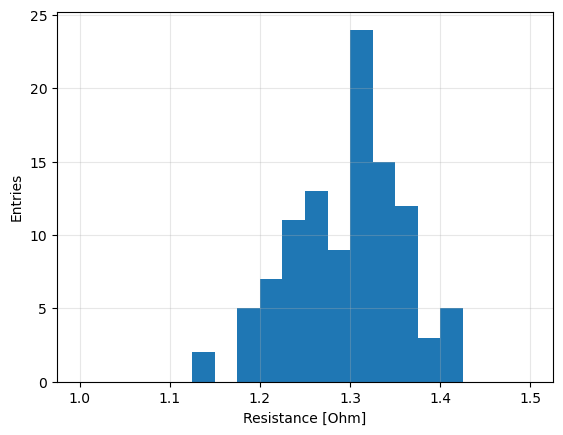

In [ ]:
fig, ax = plt.subplots()

hist = Hist.new.Regular(bins=20,
                        start=1,
                        stop=1.5,
                        name="TEC resistance",
                        underflow=True,
                        overflow=True,
                        ).Double()
hist.fill(tec_data["resistance"])
hist.plot(ax=ax, histtype="fill", )
#ax.set_yscale("log")
ax.set_xlabel("Resistance [Ohm]")
ax.set_ylabel("Entries")
plt.grid(alpha=0.3)
plt.show()

In [18]:
Pt_1000_data = plotter.merge_dataframes_for_test("Pt_1000")
Pt_1000_data

,tester_ID,chipID,resistance,pass
SN,,,,
334,0,0,3.483660,True
334,0,1,2.729534,True
290,1,0,3.280899,True
290,1,1,2.616172,True
341,3,0,3.370933,True
...,...,...,...,...
108,5,1,2.712882,True
103,6,0,3.331901,True
103,6,1,2.617512,True


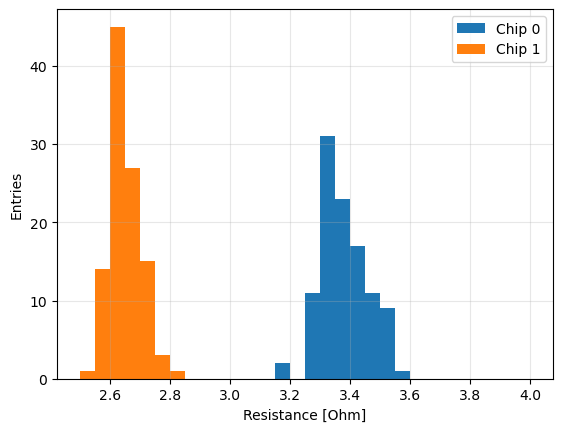

In [19]:
fig, ax = plt.subplots()
for chip_id in Pt_1000_data["chipID"].unique():
    hist = Hist.new.Regular(bins=30,
                            start=2.5,
                            stop=4,
                            name="Pt_1000 resistance",
                            underflow=True,
                            overflow=True,
                            ).Double()
    hist.fill(Pt_1000_data[Pt_1000_data["chipID"] == chip_id]["resistance"])
    hist.plot(ax=ax, histtype="fill", label=f"Chip {chip_id}")
    #sns.histplot(Pt_1000_data[Pt_1000_data["chipID"] == chip_id]["resistance"], ax=ax, bins=20)


ax.legend()
ax.set_xlabel("Resistance [Ohm]")
ax.set_ylabel("Entries")
plt.grid(alpha=0.3)
plt.show()

In [20]:
capup_data = plotter.merge_dataframes_for_test("CaPup")
capup_data

,tester_ID,current,pass
SN,,,
334,0,0.1360,False
290,1,0.1315,False
341,3,0.1315,False
289,4,0.1310,False
294,5,0.1320,False
...,...,...,...
101,3,0.1325,False
217,4,0.1360,False
108,5,0.1335,False


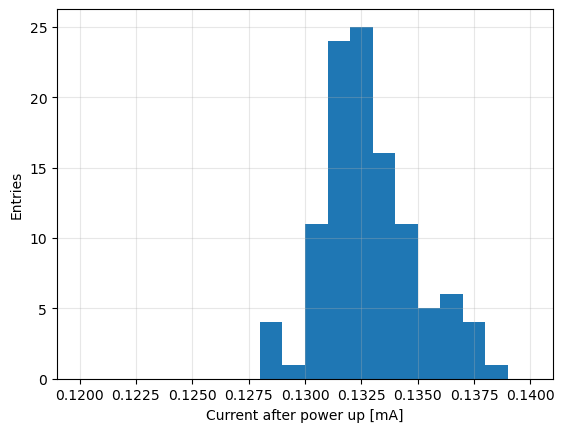

In [21]:
fig, ax = plt.subplots()
hist = Hist.new.Regular(bins=20,
                        start=0.12,
                        stop=0.14,
                        name="current after power up",
                        underflow=True,
                        overflow=True,
                        ).Double()
hist.fill(capup_data["current"])
hist.plot(ax=ax, histtype="fill")
#ax.set_yscale("log")
ax.set_xlabel("Current after power up [mA]")
ax.set_ylabel("Entries")
plt.grid(alpha=0.3)
plt.show()

In [22]:
ca_init_data = plotter.merge_dataframes_for_test("CaInit")
ca_init_data

,tester_ID,current
SN,,
334,0,0.8105
290,1,0.8085
341,3,0.8105
289,4,0.8060
294,5,0.8050
...,...,...
101,3,0.8030
217,4,0.8000
108,5,0.8040


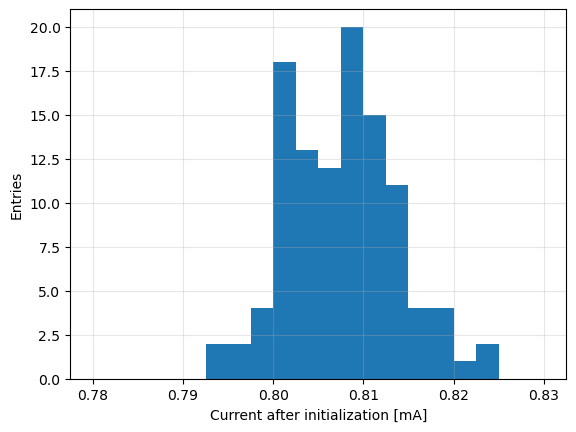

In [26]:
fig, ax = plt.subplots()
hist = Hist.new.Regular(bins=20,
                        start=0.78,
                        stop=0.83,
                        name="current after initialization",
                        underflow=True,
                        overflow=True,
                        ).Double()
hist.fill(ca_init_data["current"])
hist.plot(ax=ax, histtype="fill")
#ax.set_yscale("log")
ax.set_xlabel("Current after initialization [mA]")
ax.set_ylabel("Entries")
plt.grid(alpha=0.3)
plt.show()

Generating plots for Aldo
Generating plots for TestPulse


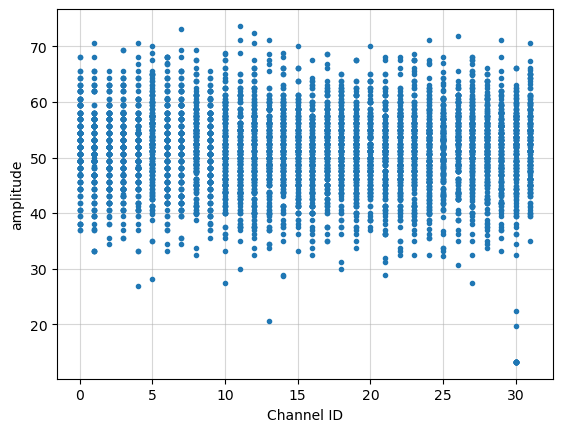

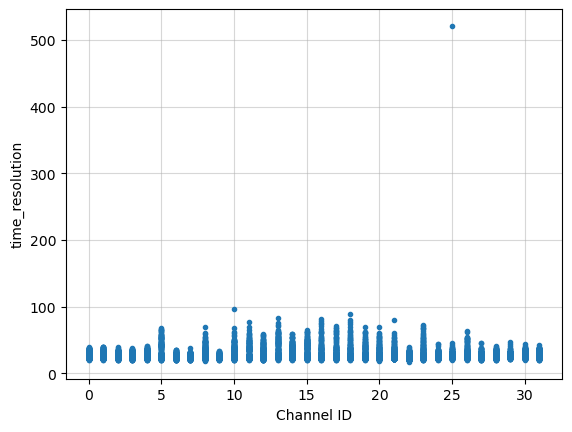

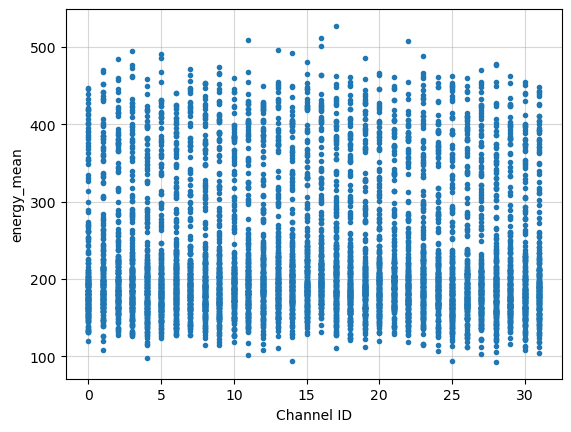

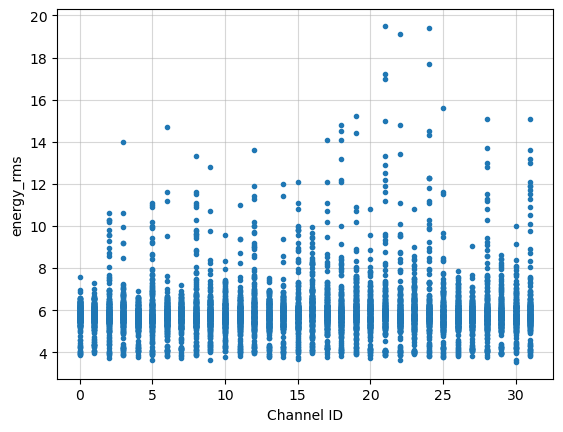

Generating plots for ExtTestPulse
Generating plots for DiscCalibration0
Generating plots for DiscCalibration1
Generating plots for DiscCalibration2
Generating plots for DiscCalibration3
Generating plots for QDCCalibration0
Generating plots for QDCCalibration1
Generating plots for QDCCalibration2
Generating plots for QDCCalibration3
Generating plots for QDCCalibration4
Generating plots for QDCCalibration5
Generating plots for QDCCalibration6
Generating plots for QDCCalibration7
Generating plots for TDCCalibration


In [5]:
plotter.generate_plots("./new_plots")